In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import random


In [2]:
image_path = "n.jpg"


In [3]:
# Source: https://stackoverflow.com/a/42314798
def plotimage(img, title=None, figsize=None, invert=False):
    """
    Function to plot an image using matplotlib.
    """
    if invert:
        img = np.max(img) - img.copy()
    
    h = img.shape[0]
    w = img.shape[1]
    dpi = 80
    if figsize is None:
        figsize = w / float(dpi), h / float(dpi)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1]) 
    ax.axis('off')
    ax.imshow(img, cmap='gray')
    if title:
        plt.title(title)
    plt.show()


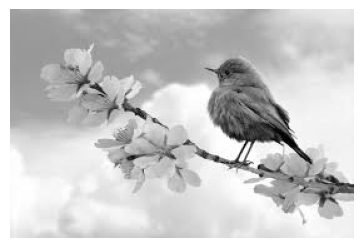

In [4]:
# Code
img = cv2.imread(image_path)

# Check if the image was loaded successfully
if img is None:
    print(f"Error: Unable to load image at {image_path}")
else:
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    plotimage(img)


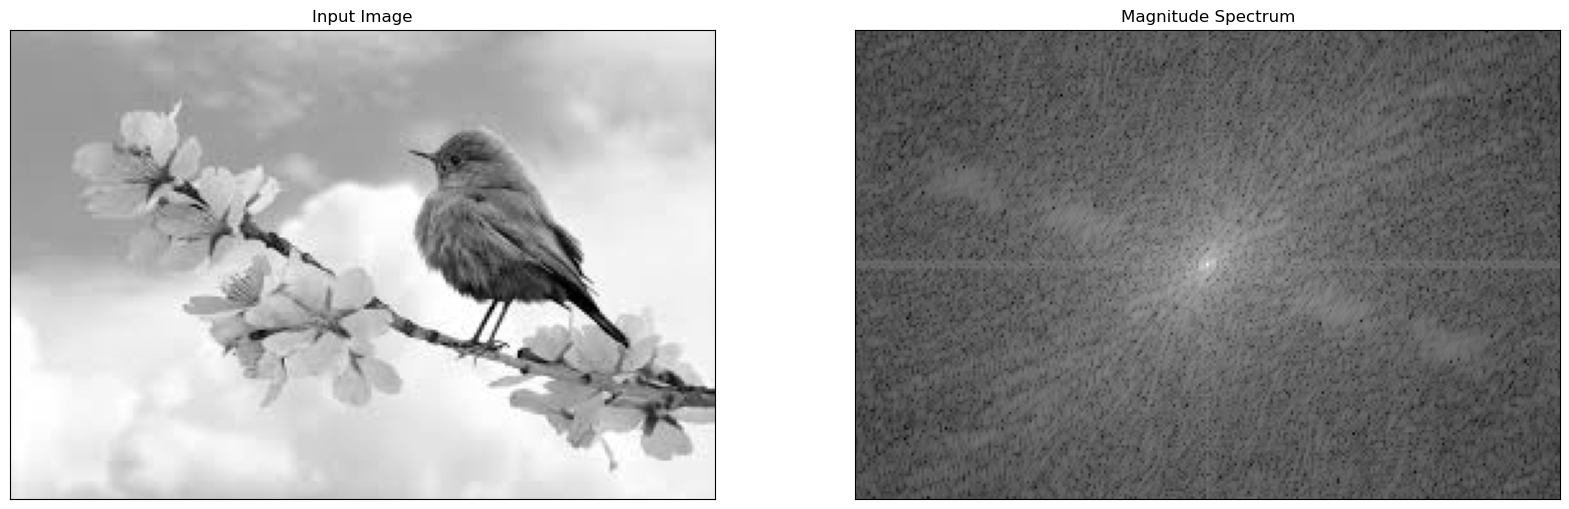

In [5]:
if img is not None:
    # Fourier Transform
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    # for plotting
    magnitude_spectrum = 20 * np.log(np.abs(fshift))
    plt.figure(figsize=(20, 20))
    plt.subplot(121), plt.imshow(img, cmap='gray')
    plt.title('Input Image'), plt.xticks([]), plt.yticks([])
    plt.subplot(122), plt.imshow(magnitude_spectrum, cmap='gray')
    plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
    plt.show()


In [6]:
def get_filter(r, c, w1, w2=None, mode='lpf'):
    """
    Function to create various filters.
    """
    if mode == 'lpf' or mode == 'hpf':
        pf = np.zeros((r, c), dtype='uint8')
        crow, ccol = r // 2, c // 2 
        cv2.circle(pf, (ccol, crow), w1, 1, -1)
        if mode == 'lpf':
            return pf
        if mode == 'hpf':
            return 1 - pf
    elif mode == 'bpf' or mode == 'bsf':
        hpf = get_filter(r=r, c=c, w1=w1, mode='hpf')
        lpf = get_filter(r=r, c=c, w1=w2, mode='lpf')
        bpf = hpf * lpf
        if mode == 'bpf':
            return bpf
        if mode == 'bsf':
            return 1 - bpf
    elif mode in ('blpf', 'bhpf', 'glpf', 'ghpf'):
        w, h = c, r 
        x, y = np.meshgrid(list(range(w)), list(range(h)))
        center = (w // 2, h // 2)
        z = np.sqrt(np.square(x - center[0]) + np.square(y - center[1]))
        if mode in ('blpf', 'bhpf'):
            b = 1 / (1 + np.square(z / w1))
            if mode == 'blpf': 
                return b
            if mode == 'bhpf':
                return 1 - b
        if mode in ('glpf', 'ghpf'):
            b = np.exp(-np.square(z) / (2 * np.square(w1)))
            if mode == 'glpf': 
                return b
            if mode == 'ghpf':
                return 1 - b
    return None


In [7]:
def apply_filter(f_shifted, w1=50, w2=None, mode='lpf', return_filter=False):
    """
    Function to apply a filter to the Fourier transformed image.
    """
    rows, cols = f_shifted.shape
    
    f_shifted = f_shifted.copy()
    
    w1 = min(min(f.shape[0], f.shape[1]), w1)
    if w2 is not None:
        w2 = min(min(f.shape[0], f.shape[1]), w2)
    
    if mode == 'bpf' or mode == 'bsf':
        if w2 is None:
            raise Exception("Error! 'w2' should be specified for this kind of filter!")
    
    pf = get_filter(r=f.shape[0], c=f.shape[1], w1=w1, w2=w2, mode=mode)
    
    if return_filter:
        return f_shifted * pf, pf
    return f_shifted * pf


In [8]:
def HPF(f_shifted, w0=50):
    """
    Function to apply a high-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='hpf')


In [9]:
def LPF(f_shifted, w0=50):
    """
    Function to apply a low-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='lpf')


In [10]:
def BPF(f_shifted, w1=50, w2=100):
    """
    Function to apply a band-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w1, w2=w2, mode='bpf')


In [11]:
def BSF(f_shifted, w1=50, w2=100):
    """
    Function to apply a band-stop filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w1, w2=w2, mode='bsf')


In [12]:
def BLPF(f_shifted, w0=50):
    """
    Function to apply a Butterworth low-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='blpf')


In [13]:
def BHPF(f_shifted, w0=50):
    """
    Function to apply a Butterworth high-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='bhpf')


In [14]:
def GLPF(f_shifted, w0=50):
    """
    Function to apply a Gaussian low-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='glpf')


In [15]:
def GHPF(f_shifted, w0=50):
    """
    Function to apply a Gaussian high-pass filter.
    """
    return apply_filter(f_shifted=f_shifted, w1=w0, mode='ghpf')


C:\Users\Student\AppData\Local\Temp\ipykernel_6928\874893744.py:20: RuntimeWarning: divide by zero encountered in log
  magnitude_spectrum = 20 * np.log(np.abs(fshift_filtered))


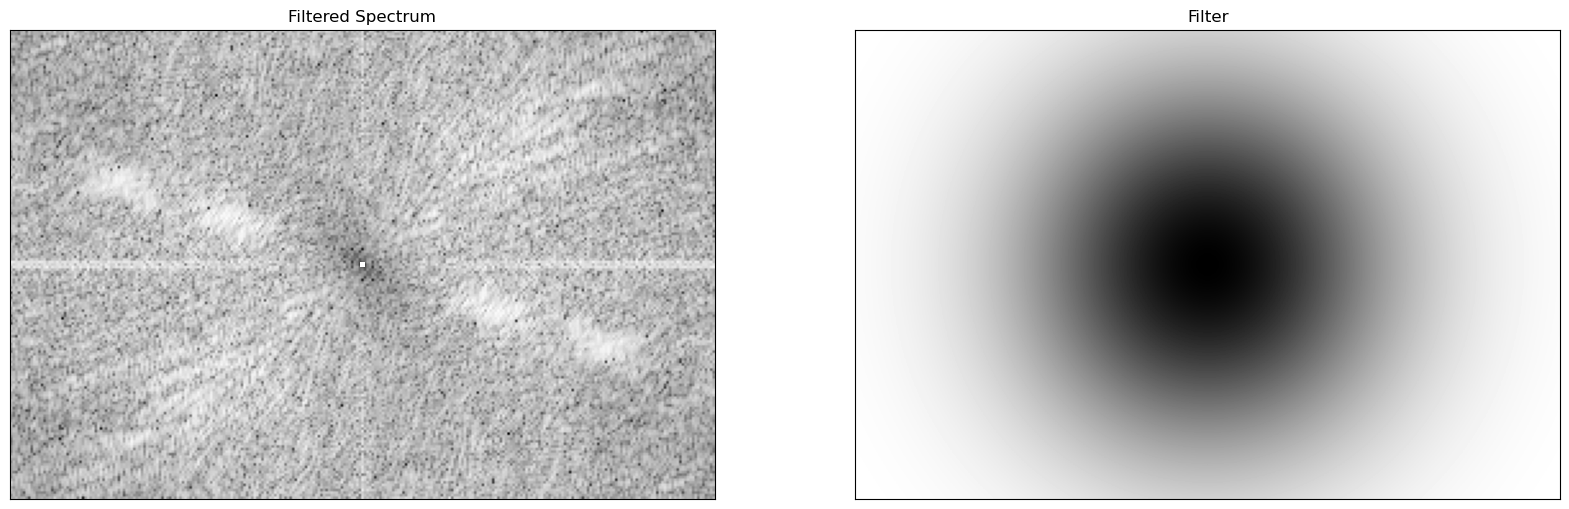

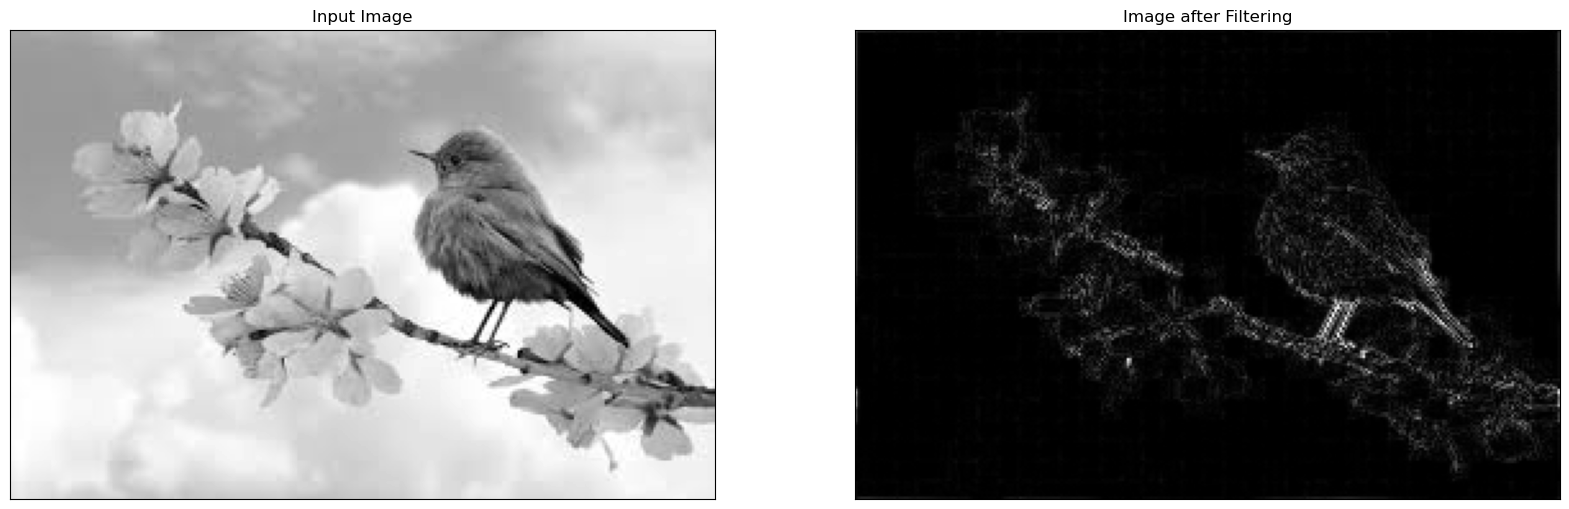

In [16]:
# Set filter parameters
filter_name = 'ghpf'  # Filter type: Gaussian high-pass filter
w1 = 50  # Filter parameter
w2 = None  # Optional second filter parameter (not used in this filter)

# Apply the specified filter to the Fourier-transformed image
fshift_filtered, filter = apply_filter(f_shifted=fshift, w1=w1, w2=w2, mode=filter_name, return_filter=True)

# Perform the inverse FFT shift
f_ishift = np.fft.ifftshift(fshift_filtered)

# Perform the inverse FFT to get the filtered image back in the spatial domain
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

# Plot the results
plt.figure(figsize=(20, 20))

# Plot the magnitude spectrum of the filtered Fourier-transformed image
magnitude_spectrum = 20 * np.log(np.abs(fshift_filtered))
plt.subplot(121), plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])

# Plot the filter used
plt.subplot(122), plt.imshow(filter, cmap='gray')
plt.title('Filter'), plt.xticks([]), plt.yticks([])

# Plot the original and filtered images
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_back, cmap='gray')
plt.title('Image after Filtering'), plt.xticks([]), plt.yticks([])

plt.show()
